In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm

In [2]:
celebs = os.listdir("../cropped_faces")
faces = []

for celeb in celebs:
    faces.append(np.asarray(Image.open("../cropped_faces/{}".format(celeb))))

face_array = np.array(faces)
red, green, blue = np.split(face_array, 3, axis=3)

In [3]:
def get_random_face():
    index = np.random.randint(0, len(face_array))
    return faces[index], index


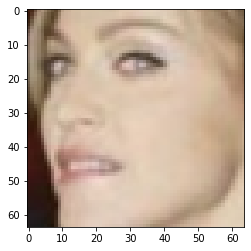

In [4]:
plt.imshow(get_random_face()[0], cmap=plt.cm.rainbow)


In [5]:
def pca(X, n_pc):
    mean = np.mean(X, axis=0)
    centered_data = X - mean # Subtracting the mean from the data
    U, S, V = np.linalg.svd(centered_data) # Taking the SVD from the data
    components = V[:n_pc] # Extracting the principal components
    projected = U[:,:n_pc]*S[:n_pc]

    return projected, components, mean, centered_data

In [6]:
def eigenfaces(data, faces=50):
    samples, h, w, d = data.shape
    X = data.reshape(samples, h*w) # vectorizing the images
    P, C, M, Y = pca(X, n_pc=faces) # running PCA with the number of principal components specified
    return C.reshape((faces, h, w)), P, C, M, Y #reshaping the principal components to be images

def reconstruct(mean_centered, components, mean, index):
    weights = np.dot(mean_centered, components.T)
    centered_vector = np.dot(weights[index, :], components) # applying weights to each of the components
    recovered = (mean + centered_vector).reshape(64, 64)
    return recovered

In [7]:
def accuracy(original, reconstruction):
    difference = original - reconstruction
    sum = np.sum(np.abs(difference))
    return sum / np.sum(original)

In [ ]:
eigenface_dict = dict()
accuracies = dict()

for num_faces in range(50, 1000, 50):
    print("Computing {} Eigenfaces".format(num_faces))
    red_eigenface_array, P_r, C_r, M_r, Y_r = eigenfaces(red, num_faces)
    green_eigenface_array, P_g, C_g, M_g, Y_g = eigenfaces(green, num_faces)
    blue_eigenface_array, P_b, C_b, M_b, Y_b = eigenfaces(blue, num_faces)
    print("Finished Eigenfaces")

    eigenface_dict[num_faces] = ((red_eigenface_array, P_r, C_r, M_r, Y_r), (green_eigenface_array, P_g, C_g, M_g, Y_g), (blue_eigenface_array, P_b, C_b, M_b, Y_b))
    accuracies[num_faces] = list()

    for face in tqdm(range(1000)):
        reconstruction = np.dstack((
            reconstruct(Y_r, C_r, M_r, face),
            reconstruct(Y_g, C_g, M_g, face),
            reconstruct(Y_b, C_b, M_b, face)
        ))

        accuracies[num_faces].append(accuracy(faces[face], reconstruction))

Computing 50 Eigenfaces
Finished Eigenfaces


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
accuracy_df = pd.DataFrame.from_dict(accuracies)
accuracy_df

In [ ]:
accuracy_df = 1 - accuracy_df

In [ ]:
plt.title("Accuracy of Reconstruction vs. Number of Eigenfaces")
accuracy_df.boxplot()